In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import interp1d

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-05-30 12:30:01.053560: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-05-30 12:30:01.053583: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Average density

In [4]:
abacus_halos = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}.npy'.format(z))
abacus_particles = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003.npy'.format(z))
nbar = abacus_halos.size/(boxsize**3)

In [5]:
nbar

0.003442710625

In [6]:
abacus_particles.size/(boxsize**3)

0.00309588575

## Gaussian model

In [7]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=nbar, damping=False, non_linear=True)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


## Shot noise

In [8]:
# shot noise correction for sigma_RR
fourier_kernel = model.smoothing_kernel_3D
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
w2 = integrate_pmesh_field(real_space_kernel**2)
shotnoise_halos = w2 / nbar

In [9]:
shotnoise_particles = w2 / (abacus_particles.size/(boxsize**3))

In [10]:
print(shotnoise_halos)
print(shotnoise_particles)

0.017755870972930878
0.019745019871821246


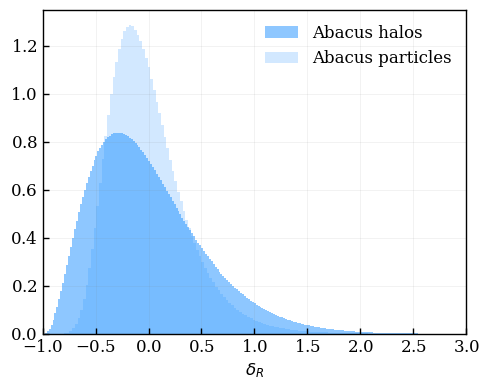

In [11]:
abacus_halos_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_halos2_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R.npy'.format(1.175, cellsize, resampler))

pdf_halos = plt.hist(abacus_halos_delta_R, bins=300, density=True, alpha=0.5, color='C0', label=r'Abacus halos')
pdf_particles = plt.hist(abacus_particles_delta_R, bins=300, density=True, alpha=0.2, color='C0', label=r'Abacus particles')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

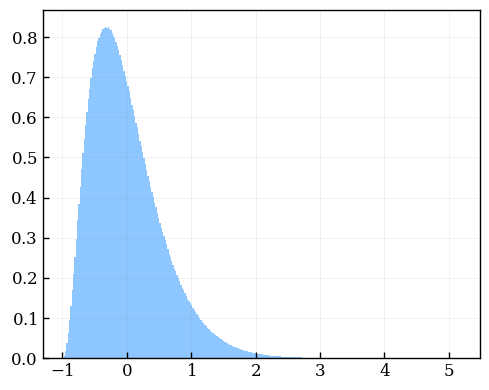

In [12]:
pdf_halos2 = plt.hist(abacus_halos2_delta_R, bins=300, density=True, alpha=0.5, color='C0', label=r'Abacus halos')

In [13]:
print(np.mean(abacus_particles_delta_R))
print(np.mean(abacus_halos_delta_R))

-9.332350889368052e-05
-4.6031561491820734e-06


In [14]:
np.sqrt((np.mean(abacus_halos_delta_R**2) - shotnoise_halos)/(np.mean(abacus_particles_delta_R**2) - shotnoise_particles))

1.5021817537167566

In [15]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

## Dark matter particles (no bias)

In [16]:
def compute_delta0_sigma_from_moments(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = np.mean(delta_R**2) #moment(delta_R, 2)
    if m3 is None:
        m3 = np.mean(delta_R**3) #moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0, sigma = compute_delta0_sigma_from_moments(abacus_particles_delta_R)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2987382549221138e-11
        x: [ 9.711e-01]
      nit: 4
      jac: [ 4.803e-07]
 hess_inv: [[ 1.174e+02]]
     nfev: 14
     njev: 7


In [17]:
print('delta0:', delta0)
print('sigma:', sigma)

delta0: 0.9711193674625868
sigma: 0.3661967062628833


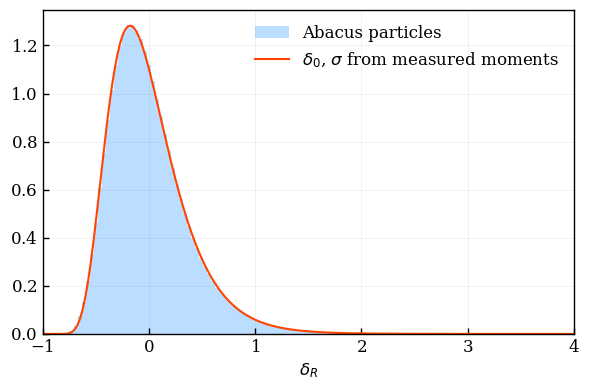

In [18]:
plt.rcParams["figure.figsize"] = (6, 4)

plt.hist(abacus_particles_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus particles')
plt.plot(delta, friedrich_lognormal_model(delta, sigma, delta0), color='C1', ls='-', label=r'$\delta_0$, $\sigma$ from measured moments')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
#plt.yscale('log')
#plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

## Model with bias

In [135]:
def bias_model(delta_m, sigma_m, b1, b2, b3=None, delta3=None):
    res = b1 * delta_m + b2 * (delta_m**2 - sigma_m**2)
    if b3 is not None:
        if delta3 is None:
            print('Error: delta3 needs to be specified for third order expansion.')
        else:
            res += b3*(delta_m**3 - delta3)
    return res

def gaussian_bias_model(delta_m, mu, s, N):
    return N * np.exp(- (delta_m - mu)**2 / (2 * s**2)) -1

def get_unbiased_delta(delta, b1, b2, sigma, b3=None, delta3=None):
    #def tomin(deltam):
    #    return (delta - bias_model(deltam, sigma, b1, b2, b3, delta3))**2
    #res = minimize(tomin, x0=delta)
    if b3 is not None:
        res = np.polynomial.polynomial.Polynomial(np.array([- delta - b2*sigma**2 - b3*delta3, b1, b2, b3])).roots()
    else:
        res = np.polynomial.polynomial.Polynomial(np.array([- delta - b2*sigma**2, b1, b2])).roots()
    #return res.x[0]
    realres = res[np.isreal(res)].real
    return realres[np.argmin((delta - b1*realres)**2)]

#def get_unbiased_delta_num(delta, b1, b2, sigma):
#    if b2==0:
#        return delta/b1
#    else:
#        res = np.zeros(len(delta))
#        mask = b1**2 + 4*b2*(b2*sigma**2+delta) < 0
#        res[mask] = -b1/(2*b2)
#        r1 = (-b1 - np.sqrt(b1**2 + 4*b2*(b2*sigma**2+delta[~mask])))/(2*b2)
#        r2 = (-b1 + np.sqrt(b1**2 + 4*b2*(b2*sigma**2+delta[~mask])))/(2*b2)
#        r = np.maximum(r1, r2)
#        res[~mask] = r
#        return res

def biased_lognormal_model(delta, sigma, delta0, b1, b2, b3=None, return_deltam=True):
    delta2 = delta0**2*(np.exp(sigma**2)-1)
    if b3 is not None:
        delta3 = delta2**3/delta0**3 + 3*delta2**2/delta0
    else:
        delta3 = None
    deltam1 = np.array([get_unbiased_delta(d, b1, b2, np.sqrt(delta2), b3, delta3) for d in delta])
    norm = np.abs(b1 + 2*b2*deltam1) if b3 is None else np.abs(b1 + 2*b2*deltam1 + 3*b3*deltam1**2)
    pdf_model1 = scipy.stats.lognorm.pdf(deltam1, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))/norm
    return pdf_model1#, pdf_model2

def biased_lognormal_model_test(deltam, sigma, delta0, b1, b2, b3=None):
    delta2 = delta0**2*(np.exp(sigma**2)-1)
    if b3 is not None:
        delta3 = delta2**3/delta0**3 + 3*delta2**2/delta0
    else:
        delta3 = None
    deltah = bias_model(deltam, sigma, b1, b2, b3, delta3)
    norm = np.abs(b1 + 2*b2*deltam) if b3 is None else np.abs(b1 + 2*b2*deltam + 3*b3*deltam**2)
    pdf_model = scipy.stats.lognorm.pdf(deltam, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))/norm
    deltah_pdf_model = interp1d(deltah, pdf_model, bounds_error=False, fill_value=0)
    return deltah_pdf_model

def gaussianbiased_lognormal_model(deltam, sigma, delta0, mu, s, N):
    deltah = gaussian_bias_model(deltam, mu, s, N)
    norm = s**2/(N*np.abs(deltam-mu))*np.exp((deltam-mu)**2/(2*s**2))
    pdf_model = scipy.stats.lognorm.pdf(deltam, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))*norm
    deltah_pdf_model = interp1d(deltah, pdf_model, bounds_error=False, fill_value=0)
    return deltah_pdf_model

In [136]:
m2 = np.mean(abacus_particles_delta_R**2) - shotnoise_particles + shotnoise_halos
sigma_hsn = np.sqrt(np.log(1 + (m2/delta0**2)))

In [137]:
sigma_hsn

0.3636671628579655

In [138]:
sigma

0.3661967062628833

In [139]:
delta = np.linspace(-1, 20, 100000)

def compute_bias(x, fx, sigma, delta0):
    
    def to_fit(x, *params):
        b1 = params[0]
        b2 = params[1]
        b3 = params[2]
        #y = biased_lognormal_model_test(delta, sigma, delta0, b1, b2, b3)(x)
        y = gaussianbiased_lognormal_model(delta, sigma, delta0, b1, b2, b3)(x)
        return y

    res = curve_fit(to_fit, x, fx, p0=np.array([1., 1., 1.]))
    print(res)
    #b1 = res.x[0]
    #b2 = res.x[1]
    #b3 = res.x[2]
    return res[0]

x = (pdf_halos[1][1:]+pdf_halos[1][:-1])/2.
fx = pdf_halos[0]
res = compute_bias(x, fx, sigma_hsn, delta0)    

(array([1.00005369, 0.99999352, 1.00002082]), array([[ 5.62154835e-12, -6.17274823e-13,  3.48570404e-13],
       [-6.17274823e-13,  6.94689354e-12, -7.77468680e-12],
       [ 3.48570404e-13, -7.77468680e-12,  9.98694736e-12]]))


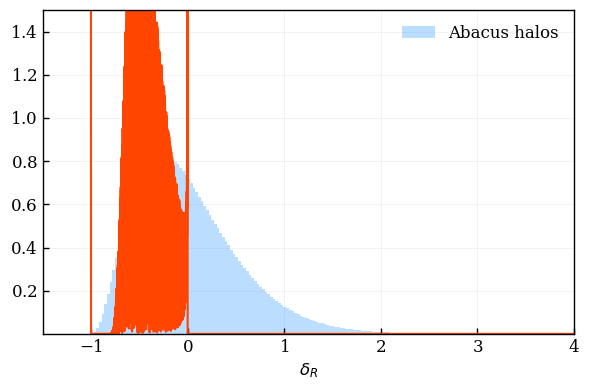

In [140]:
plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos')
#plt.plot(delta, biased_lognormal_model_test(delta, sigma_hsn, delta0, res[0], res[1], res[2])(delta), color='C1', ls='-', label=r'best fit $b_1$, $b_2$, $b_3$')
plt.plot(delta, gaussianbiased_lognormal_model(delta, sigma_hsn, delta0, res[0], res[1], res[2])(delta), color='C1', ls='-')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.5, 4))
#plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0008403436537075719
        x: [ 1.127e+00  6.178e-01  9.405e-01  3.983e-01  6.885e-02]
      nit: 50
      jac: [ 1.815e-06 -2.037e-07 -2.891e-06 -8.335e-08 -7.541e-06]
 hess_inv: [[ 6.410e-01 -1.344e+00 ... -2.425e+00  2.595e-01]
            [-1.344e+00  2.973e+00 ...  5.355e+00 -5.590e-01]
            ...
            [-2.425e+00  5.355e+00 ...  1.004e+01 -1.045e+00]
            [ 2.595e-01 -5.590e-01 ... -1.045e+00  1.139e-01]]
     nfev: 354
     njev: 59


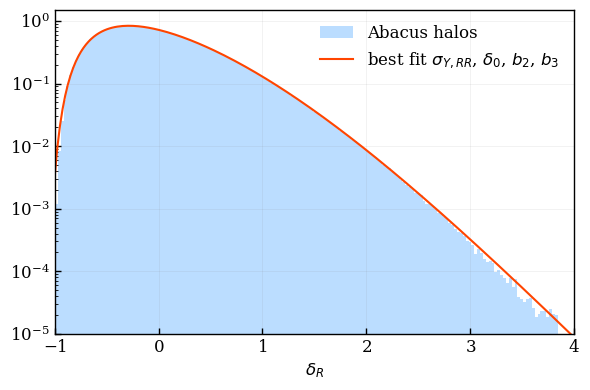

In [98]:
def biased_lognormal_model(delta, sigma, delta0, b1, b2, b3):
    delta2 = delta0**2*(np.exp(sigma**2)-1)
    delta3 = 3/delta0**2*delta2 + 1/delta0**3*delta2**(3./2)
    delta_bias = b1*delta + b2/2.*(delta**2 - delta2) + b3*(delta**3 - delta3)
    pdf_model = scipy.stats.lognorm.pdf(delta_bias, sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

def compute_bestfit_delta0_sigma_4(delta_R_pdf):
    x = (delta_R_pdf[1][1:]+delta_R_pdf[1][:-1])/2.
    fx = delta_R_pdf[0]

    def to_min(params):
        delta0 = params[0]
        sigma = params[1]
        b1 = params[2]
        b2 = params[3]
        b3 = params[4]
        y = biased_lognormal_model(x, sigma, delta0, b1, b2, b3)
        return np.sum((fx-y)**2)

    res = minimize(to_min, x0=np.array([1., model.sigma_RR[0], 1., 0., 0.]))
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    b1 = res.x[2]
    b2 = res.x[3]
    b3 = res.x[4]
    return delta0, sigma, b1, b2, b3
    
delta0_4, sigma_4, b1, b2, b3 = compute_bestfit_delta0_sigma_4(pdf_halos)    

plt.rcParams["figure.figsize"] = (6, 4)

plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus halos')
plt.plot(delta, biased_lognormal_model(delta, sigma_4, delta0_4, b1, b2, b3), color='C1', ls='-', label=r'best fit $\sigma_{Y, RR}$, $\delta_0$, $b_2$, $b_3$')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.savefig('../../plots/density_bias_model_inverse_order3_logscale.png')
plt.show()